### This notebook is to answer the RQ4: How does technical lag propagate over transitive runtime dependencies?

In [37]:
%matplotlib inline
import seaborn as sns; #sns.set(style="ticks", color_codes=True)
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import style
import scipy
style.use('fast')
from datetime import datetime

sns.set_style('ticks',{'legend.frameon':True} )
sns.set_palette('colorblind')

plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42
plt.rcParams['text.usetex'] = True

plt.rcParams['xtick.labelsize'] = 18
plt.rcParams['ytick.labelsize'] = 22
plt.rcParams['axes.labelsize']= 22

PALETTE_BASE = sns.color_palette('muted', n_colors=12)
blue=PALETTE_BASE[0]
green=PALETTE_BASE[1] 
red=PALETTE_BASE[2] 
purple=PALETTE_BASE[3]
version_colors=['orange',red, 'gray']

# LOAD THE TRANSITIVE TECHNICAL LAG EVOLUTION
Note that because of memory errors, this dataframe is filtred from packages with zero techlag or without any dependencies.

It is also filtred from the spam packages and pre releases.

The origine dataframe size is: 163,867,660 rows

In [2]:
df_all=pd.read_csv('../../../jsep2018/csv/transitive/transitive_lag_filtred.csv', sep=';', dtype=object, index_col=None,  error_bad_lines=False)
len(df_all)

62889161

In [101]:
print('Which means that {} of all dependencies are outdated.'.format(62889161*100/163867660))

Which means that 38.3780185791388 of all dependencies are outdated.


In [3]:
first_date="2010-12-01"
last_date="2018-04-30"
date_period = pd.to_datetime(first_date), pd.to_datetime(last_date)

In [4]:
for x in ['Patch','Minor','Major','time_lag','level']:
    df_all[x]=df_all[x].apply(float)

The next code is just to explore.

Skip it until code until the analysis of version lag

In [5]:
df_all.rename(columns={'package_root':'package'}, inplace=True)

In [10]:
df_all.package.drop_duplicates().size

545676

In [7]:
df_all['package2']=df_all['package'].apply(lambda x: '@'.join(x.split('@')[:-1]))
df_all['dependency2']=df_all['dependency'].apply(lambda x: '@'.join(x.split('@')[:-1]))

In [8]:
df_all[['package','dependency2']].drop_duplicates().size

14368250

In [9]:
df_all.package2.drop_duplicates().size

65535

In [10]:
df_all.dependency2.drop_duplicates().size

46949

In [11]:
df_all[['package','date']].drop_duplicates().size

991088

In [12]:
df_all.package.drop_duplicates().size

158197

In [13]:
df_all.dependency.drop_duplicates().size

125875

In [14]:
df_all.dependency.size

24904066

In [15]:
df_all.package.size

24904066

In [16]:
df_all.dependency.drop_duplicates().size

125875

# Analysis: Only outdated dependencies

In [6]:
df_all=df_all.query('time_lag!=0')
df_all['date']=df_all['date'].apply(lambda x: '2018-03-30' if x=="2018-04-30"
                                   else x)
len(df_all)

62889161

# Version lag aggregation

In [7]:
df_all_sum=(df_all.head(62889161)
            .drop(['time_lag','level','dependency'],axis=1)
            .groupby(['package','date'])
            .sum()
           )

In [9]:
df_all_sum.reset_index(inplace=True)
df_all_sum['date']=df_all_sum['date'].apply(lambda x : str(x).split('-')[0]+'-'+str(x).split('-')[1])
df_all_sum_melted=df_all_sum.melt(id_vars=['package','date'])
df_all_sum['date']=pd.to_datetime(df_all_sum['date'])

In [11]:
print(df_all_sum.Major.median(),
      df_all_sum.Minor.median(),
      df_all_sum.Patch.median()
     )

10.0 20.0 40.0


Patch
Minor
Major


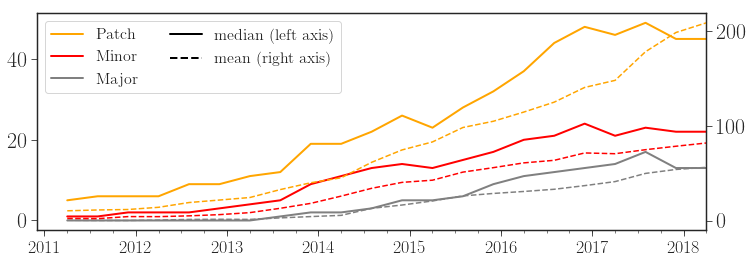

In [91]:
size=[20,30,100]
dfs={}
for x in ['Patch','Minor','Major']:
    dfs[x]=(df_all_sum.
            groupby(pd.Grouper(key='date', freq='4M'))[x].
            describe()[['mean', '25%', '50%', '75%']] 
           )

colors={}
colors['Patch']='orange'
colors['Minor']='r'
colors['Major']='gray'

for i, x in enumerate(['Major','Minor','Patch']):
    df_tmp=dfs[x]
    ax=df_tmp['50%'].rename('median').plot( color=colors[x], linewidth=2)
    ax.legend('')
    
ax.set(
    xlabel='',
    xlim=date_period,
)

ax2 = ax.twinx()

for i, x in enumerate(['Major','Minor','Patch']):
    df_tmp=dfs[x]
    ax2=df_tmp['mean'].plot(style='--', ax=ax2, color=colors[x])
    ax.legend('')
ax2.set(
    xlabel='',
    xlim=date_period,
)

ax.figure.set_size_inches(12,4)

from matplotlib.lines import Line2D
lines = []
labels = []
for key in ['Patch','Minor','Major']:
    lines.append(Line2D([0], [0], color=colors[key], linewidth=2))
    labels.append(key)
lines.append(Line2D([0], [0], color='black', linewidth=2))
labels.append('median (left axis)')
lines.append(Line2D([0], [0], color='black', linewidth=2, linestyle='--'))
labels.append('mean (right axis)')
ax.legend(lines, labels, ncol=2, loc='upper left',  prop={'size': 16, 'weight':'bold'})
# ax.figure.savefig('/home/neglectos/Desktop/repositories/jsep18technicallag/figures/transitive_vl.pdf', bbox_inches='tight', facecolor='white')

# Time lag aggregation

In [33]:
df_all_time = (df_all.head(62889161)
  .drop(['Major','Minor','Patch','level','dependency'],axis=1)
 .groupby(['package','date'])
 .agg('max')
 .reset_index()
)
df_all_time['date']=df_all_time['date'].apply(lambda x : str(x).split('-')[0]+'-'+str(x).split('-')[1])
df_all_time['date']=pd.to_datetime(df_all_time['date'])

In [34]:
df_all_time['date']=pd.to_datetime(df_all_time['date'])

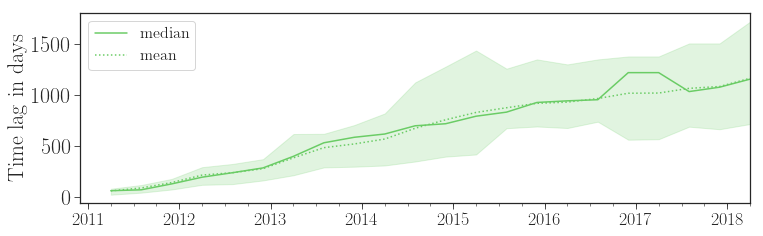

In [42]:
size=[12,20,70]
df_=(df_all_time.
     groupby(pd.Grouper(key='date', freq='4M'))['time_lag'].
     describe()[['mean', '25%', '50%', '75%']] 
    )

df_tmp=df_
df_tmp['50%'].rename('median').plot(color=green)
ax=df_tmp['mean'].plot(style=':',color=green)
ax.fill_between(df_tmp.index, df_tmp['25%'], df_tmp['75%'], alpha=0.2, color=green)

ax.set(
    xlabel='',
    ylabel='Time lag in days',
    xlim=date_period,
)
ax.legend(loc='upper left',  prop={'size': 16, 'weight':'bold'})
ax.figure.set_size_inches(12,3.5)
ax.figure.savefig('/home/neglectos/Desktop/repositories/jsep18technicallag/figures/transitive_tl.eps', bbox_inches='tight', facecolor='white')

In [72]:
# Compute R²
slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(df_tmp.reset_index().reset_index().index,
                       df_tmp.reset_index().reset_index()['50%'])
print ("r-squared:", r_value**2)

r-squared: 0.958640552901


# Time lag evolutoin w.r.t to dependency tree depth

In [43]:
tmp_df=df_all.head(62889161)[['package','date','level']].groupby(['package','date']).max().reset_index()
tmp_df['date']=tmp_df['date'].apply(lambda x : str(x).split('-')[0]+'-'+str(x).split('-')[1])
tmp_df['date']=pd.to_datetime(tmp_df['date'])

In [44]:
time_lag_depth=(df_all_time[['package','date','time_lag']].set_index(['package','date']).
                merge(tmp_df.set_index(['package','date']),
                      left_index=True,
                      right_index=True,
                      how='left'
                     )
                .reset_index()
                #.dropna()
               )
len(time_lag_depth)

2104051

In [45]:
time_lag_depth['level'] = time_lag_depth['level'].astype(int)

#### only for 2018

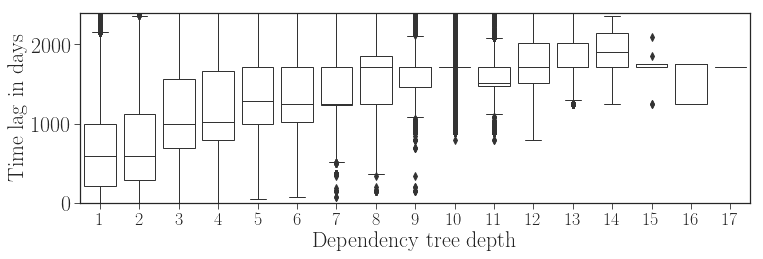

In [95]:
ax = sns.boxplot(x="level", 
                 y="time_lag", 
                 data=time_lag_depth.query('date == "2018-03-01"').query('level<18'),
                 color="white", linewidth=1, saturation=0.5)
plt.setp(ax.lines, color=".2", mfc='.2', mec='.2')
for x in ax.artists:
    x.set_edgecolor('.2')
ax.figure.set_size_inches(12,3.5)
ax.set_xlabel("Dependency tree depth")
ax.set_ylabel('Time lag in days')
for patch in ax.patches:
    patch.set_edgecolor('black')
ax.set_ylim(0,2400)
ax.legend(loc='upper right',  bbox_to_anchor=(0.8, 1.3), ncol=3, fontsize=20, fancybox=True, shadow=True)
ax.figure.savefig('/home/neglectos/Desktop/repositories/jsep18technicallag/figures/dependency_tree_depth.eps', bbox_inches='tight', facecolor='white')

#### For all years 

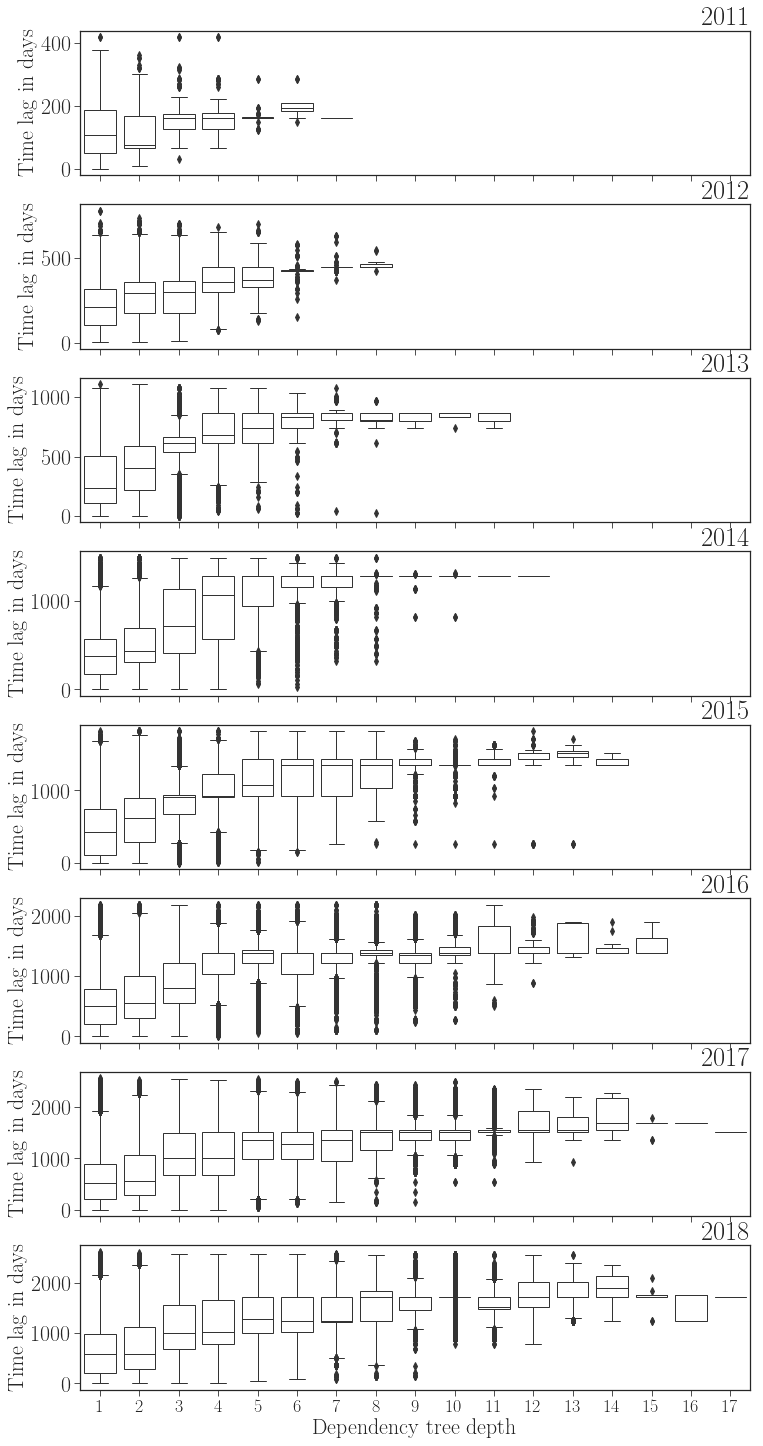

In [83]:
fig, axes = plt.subplots(8, 1, sharex=True, sharey=False)
for i, year in enumerate(range(2011,2019)):
    date = str(year)+'-12-01'
    if year == 2018:
        date = '2018-03-01'
    
    time_lag_depth_year = time_lag_depth.query('date =="'+date+'"')

    
    ax = sns.boxplot(x="level", 
                     y="time_lag", 
                     ax = axes[i],
                     data=time_lag_depth_year.query('level<18'),
                     color="white", linewidth=1, saturation=0.5)
    plt.setp(ax.lines, color=".2", mfc='.2', mec='.2')
    for x in ax.artists:
        x.set_edgecolor('.2')
    ax.figure.set_size_inches(12,25)
    ax.set_title(str(year), loc='right')
    ax.set_xlabel("")
    ax.set_ylabel('Time lag in days')
    for patch in ax.patches:
        patch.set_edgecolor('black')
    ax.legend(loc='upper right',  bbox_to_anchor=(0.8, 1.3), ncol=3, fontsize=20, fancybox=True, shadow=True)
ax.set_xlabel("Dependency tree depth")
#ax.figure.savefig('/home/neglectos/Desktop/repositories/jsep18technicallag/figures/dependency_tree_depth.png', bbox_inches='tight', facecolor='white')

# Correlating the number of deps to the depth

In [96]:
df_all['level']=df_all['level'].apply(int)

In [102]:
# Onlye 2018
maximum = df_all.date.max()
df_all_deps = df_all.query('date == "'+maximum+'"')

In [103]:
df_all_deps=(df_all_deps.groupby(['package','date']).count()[['dependency']]
             .merge(df_all_deps[['package','date','level']].groupby(['package','date']).max(),
                    left_index=True,
                    right_index=True,
                    how='left'
                   )
             .dropna()
             .reset_index()
            )
len(df_all_deps)

319290

In [104]:
df_all_deps=df_all_deps[['package','dependency','level']].drop_duplicates()

In [ ]:
time_lag_depth.query('date == "2018-03-01"')

In [107]:
scipy.stats.pearsonr(df_all_deps.dependency,
                     df_all_deps.level)

(0.70484606059695654, 0.0)